# MNIST Digit Classification

<center><img src="../app/mnist-classes.png"></center>

# Setup

### Imports

In [21]:
import numpy as np 
import pandas as pd

import torch
import torchvision
import torchviz
import torchsummary

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn

### Model Config

In [22]:
# Filepath Config
data_folder="../data/"
train_file="mnist_train.csv"
test_file="mnist_test.csv"

# Data Config
split_size = 0.2
num_classes = 10
class_names = {0:"Zero", 1:"One", 2:"Two", 3:"Three", 4:"Four", 5:"Five", 6:"Six", 7:"Seven", 8:"Eight", 9:"Nine"}
img_size = 28

# Model Config
init_lr = 0.001
batch_size = 100
epochs = 5

### Utilise available devices (i.e. GPU)

In [23]:
# Utilise any available GPU resources
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device type: ", device)

Current device type:  cpu


# Utility Functions

### Data utility functions/classes

In [24]:
def load_dataset(file_name, data_folder):
    """Read input CSV file for a given file name"""
    data = pd.read_csv(data_folder + file_name)
    return data


def plot_image(label, classnames, image):
    """Plot an example image and class from the dataset, and save it to file"""
    fig1 = plt.figure(figsize=(6,6));
    fig1.tight_layout()
    print(label)
    plt.title(f"Class: {label}, Name: {classnames[label]}")
    plt.imshow(image.to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

    
class MNISTDataSet(torch.utils.data.Dataset):
    """Class for handling input CSVs as images using PIL; also handles specified image augmentation"""
    # Get the passed image vector, label vector and transform config
    def __init__(self, images, image_size, labels, transforms=None):
        self.X = images
        self.image_size = image_size
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        # Get a single image vector
        data = self.X.iloc[i, :] 
        # Reshape the vector into an image of shape 28*28
        data = np.array(data).astype(np.uint8).reshape(self.image_size, self.image_size, 1) 
        
        # Produce any transforms that are provided
        if self.transforms:
            data = self.transforms(data)
        
        # If the data is a training set, provide the label; otherwise do not
        if self.y is not None: # train/val
            return (data, self.y[i])
        else:
            return data

### Model evaluation utility functions

In [25]:
def get_num_correct(predictions, labels):
    """Compares model predictions with actual labels, returns the number of matches"""
    return predictions.argmax(dim=1).eq(labels).sum().item()


def eval_model(network, device, validation_data, validation_set_size, batch_size):
    """Evaluation with the validation set"""
    # Ensure the model is in eval mode (this disables dropout/batchnorm etc.)
    network.eval() 
    val_loss = 0
    val_correct = 0
    
    # Set all requires_grad() flags to false
    with torch.no_grad():
        # Loop through our validation data, generate predictions and 
        # add to the the loss/accuracy count for each image
        for images, labels in validation_data:
            X, y = images.to(device), labels.to(device) # to device
            
            # Get predictions
            preds = network(X) 
            # Calculate Loss
            loss = torch.nn.functional.cross_entropy(preds, y)
            
            val_correct += get_num_correct(preds, y)
            val_loss = loss.item() * batch_size

    # Print the loss and accuracy for the validation set
    print("Validation Loss: ", val_loss/batch_size)
    print("Validation Acc:  ", (val_correct/validation_set_size)*100)

    # Return loss and accuracy values
    return val_loss, ((val_correct/validation_set_size)*100)


def confusion_matrix(num_classes, validation_labels, predictions):
    """Generate and save a confusion matrix for the Neural Network"""
    
    # Generate the confusion matrix
    cmt = torch.zeros(num_classes, num_classes, dtype=torch.int32)
    for i in range(len(validation_labels)):
        cmt[validation_labels[i], predictions[i]] += 1

    # Detatch from CPU and convert to numpy array 
    cmt = cmt.cpu().detach().numpy()

    df_cm = pd.DataFrame(cmt/np.sum(cmt) *10, index = [i for i in range(num_classes)],
                        columns = [i for i in range(num_classes)])
    
    # Plot the dataframe using seaborn
    plt.figure(figsize=(12,7))
    sn.heatmap(df_cm, annot=True)
    plt.title("Neural Network Confusion Matrix", fontsize=20)

def get_n_params(model):
    """Summarizes the number of parameters in the neural network"""
    
    params_counter = 0
    for param in list(model.parameters()):
        n=1
        for s in list(param.size()):
            n = n*s
        params_counter += n
    return params_counter

### Model training utility functions

In [26]:
def train_model(network, device, optimizer, scheduler, training_data, batch_size):
    """Trains the model using the training data"""

    epoch_loss = 0
    epoch_correct = 0
    network.train() # training mode
    
    for images, labels in training_data:
        X, y = images.to(device), labels.to(device) # put X & y on device
        y_ = network(X) # get predictions
        
        # Zeros the gradients
        optimizer.zero_grad() 
        # Calculates the loss
        loss = torch.nn.functional.cross_entropy(y_, y) 
        # Computes the gradients
        loss.backward() 
        # Update weights
        optimizer.step() 
        
        epoch_loss += loss.item() * batch_size
        epoch_correct += get_num_correct(y_, y)   
        
    print("Train Loss: ", epoch_loss/batch_size)
    print("Train Acc:  ", epoch_correct/len(training_data))
    
    scheduler.step()
    return optimizer.param_groups[0]["lr"], epoch_loss, epoch_correct/len(training_data)

# Preprocessing Data

### Loading the csv data and correcting any index issues

In [27]:
train_set   = load_dataset(train_file, data_folder)
test_images = load_dataset(test_file, data_folder)
test_set, val_set = train_test_split(test_images, test_size=0.4999, random_state=42)  # Adjust test_size as needed

print(train_set.shape)
print(test_images.shape)
print(val_set.shape)

(59999, 785)
(9999, 785)
(4999, 785)


In [28]:
# Split the data into train/test splits - split_size defined in config
train_images, val_images, train_labels, val_labels = train_test_split(train_set.iloc[:, 1:], 
                                                                     train_set.iloc[:, 0], 
                                                                     test_size=split_size)

In [29]:
# Reset the index values
train_images.reset_index(drop=True, inplace=True)
val_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

In [30]:
# Remove ID column
test_images = test_images.iloc[:, 1:]

### Plot a sample image, along with label and class

0


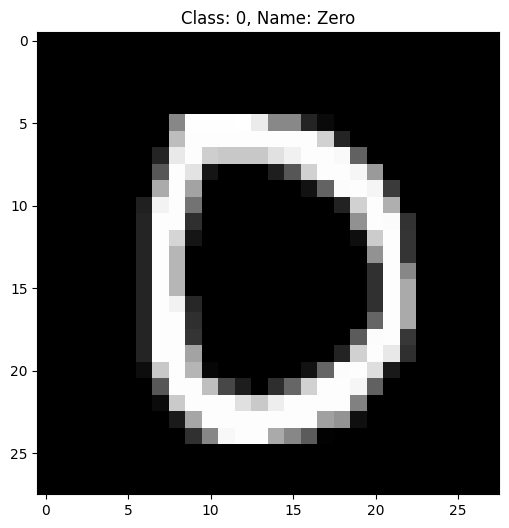

In [31]:
# Plot a sample image
plot_image(train_labels[0], class_names, train_images.iloc[[0], :])

### Performing Image Normalization and Augmentations

In [32]:
# Define transform steps to convert csv data to images, and augment training data
# ToTensor() Normalizes the image
train_trans = torchvision.transforms.Compose(([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomCrop(img_size),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2),
    torchvision.transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    torchvision.transforms.ToTensor(),
]))

# No augmentations for the validation test set
# ToTensor() Normalizes the image
test_val_trans = torchvision.transforms.Compose(([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
]))

In [33]:
# Perform our transforms and augmentations
train_set = MNISTDataSet(train_images, img_size, train_labels, train_trans)
val_set = MNISTDataSet(val_images, img_size, val_labels, test_val_trans)

# No labels for the test set
test_set = MNISTDataSet(test_images, img_size, None, test_val_trans)

# Creating the Neural Network

In [34]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # Image starts as a matrix of size (1, 28, 28)
        
        # The size of the image after each convolution or pooling layer can be obtained by: 
        # output = ((input - kernel_size + (2 * padding)) / stride) + 1
        
        # Convolutions and batch normalisations 
        # Batch norm reduces internal covariate shift
        # Normalises the input feature (subtract batch mean, divide by batch sd)
        # This speeds up neural network training times
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2) # conv1
        self.conv1_bn = torch.nn.BatchNorm2d(num_features=32)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2) # conv2
        self.conv2_bn = torch.nn.BatchNorm2d(num_features=64)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=3, stride=1, padding=1) # conv3
        self.conv3_bn = torch.nn.BatchNorm2d(num_features=128)
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels= 256, kernel_size=2, stride=1, padding=1) # conv4
        self.conv4_bn = torch.nn.BatchNorm2d(num_features=256)
        
        # Fully connected linear layers and batch normalisations
        self.fc1 = torch.nn.Linear(in_features=256*4*4, out_features=1024) # linear 1
        self.fc1_bn = torch.nn.BatchNorm1d(num_features=1024)
        self.fc2 = torch.nn.Linear(in_features=1024, out_features=512) # linear 2
        self.fc2_bn = torch.nn.BatchNorm1d(num_features=512)
        self.fc3 = torch.nn.Linear(in_features=512, out_features=256) # linear 3
        self.fc3_bn = torch.nn.BatchNorm1d(num_features=256)
        self.fc4 = torch.nn.Linear(in_features=256, out_features=64) # linear 4
        self.fc4_bn = torch.nn.BatchNorm1d(num_features=64)
        
        # Final Layer
        self.out = torch.nn.Linear(in_features=64, out_features=10) # output
        
        # Dropout
        self.dropout = torch.nn.Dropout(0.4)
    
    def forward(self, z):
            # Apply Relu then Max Pool function between each convolution layer
            z = torch.nn.functional.relu(self.conv1_bn(self.conv1(z)))            # (1, 28, 28)
            z = torch.nn.functional.max_pool2d(z, kernel_size=2, stride=2)        # (1, 14, 14)
            
            z = torch.nn.functional.relu(self.conv2_bn(self.conv2(z)))            # (1, 14, 14)
            z = torch.nn.functional.max_pool2d(z, kernel_size=2, stride=2)        # (1, 7, 7)
            
            z = torch.nn.functional.relu(self.conv3_bn(self.conv3(z)))            # (1, 7, 7)
            z = torch.nn.functional.max_pool2d(z, kernel_size=2, stride=1)        # (1, 6, 6)
            
            z = torch.nn.functional.relu(self.conv4_bn(self.conv4(z)))            # (1, 7, 7)
            z = torch.nn.functional.max_pool2d(z, kernel_size=4, stride=1)        # (1, 4, 4)
            
            # Apply Relu function between each fully connected layer
            #print(z.size())
            z = torch.nn.functional.relu(self.fc1_bn(self.fc1(z.reshape(-1, 256*4*4)))) # 256 4 4
            z = self.dropout(z)
            
            z = torch.nn.functional.relu(self.fc2_bn(self.fc2(z)))
            z = self.dropout(z)
            
            z = torch.nn.functional.relu(self.fc3_bn(self.fc3(z)))
            z = self.dropout(z)
            
            z = torch.nn.functional.relu(self.fc4_bn(self.fc4(z)))
            z = self.out(z)
            
            return z

In [35]:
net = Network().to(device)


# Model Architecture

In [36]:
torchsummary.summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 64, 14, 14]          51,264
       BatchNorm2d-4           [-1, 64, 14, 14]             128
            Conv2d-5            [-1, 128, 7, 7]          73,856
       BatchNorm2d-6            [-1, 128, 7, 7]             256
            Conv2d-7            [-1, 256, 7, 7]         131,328
       BatchNorm2d-8            [-1, 256, 7, 7]             512
            Linear-9                 [-1, 1024]       4,195,328
      BatchNorm1d-10                 [-1, 1024]           2,048
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 512]         524,800
      BatchNorm1d-13                  [-1, 512]           1,024
          Dropout-14                  [

In [37]:
# Eval mode for visualising
net.eval()

# Dummy input tensor (e.g., 1 grayscale image of size 28x28)
input_tensor = torch.randn(1, 1, 28, 28)

output = net(input_tensor)
graph = torchviz.make_dot(output, params=dict(net.named_parameters()))
graph.render("../model_evaluation/neural_network_graph", format="pdf")

# Revert to training mode
net.train()

Network(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc2_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_s

# 

# Model Training

### Create the model on the available device

### Get a summary of the number of parameters in the model

In [38]:
params = get_n_params(net)

print(f"There are {params} total parameters in the neural network.")

There are 5130506 total parameters in the neural network.


### Generate the training/validation torch.utils.datas

In [39]:
# Create dataset dataloaders
training_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

### Define the model torch.optimiser - we're using Adam here

In [40]:
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
# torch.optimizer = torch.optim.Adagrad(net.parameters(), lr=init_lr)
# torch.optimizer = torch.optim.SGD(net.parameters(), lr=init_lr, nesterov=True, momentum=0.9)

### Define the Learning Rate Scheduler

In [41]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = torch.torch.optim.lr_scheduler.ReduceLROnPlateau(torch.optimizer, mode='min')

### Train the model

In [42]:
lrs = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Run our epoch cycles
for epoch in range(epochs):
    # Print epoch cycle
    print("===============================================")
    print(f"Epoch Cycle: {epoch+1}")
    print("-----------------------------------------------")
    
    # Train the model, and append the current learning rate
    lr, tl, ta = train_model(net, device, optimizer, scheduler, training_dataloader, batch_size)
    
    lrs.append(lr)
    train_loss.append(tl/batch_size)
    train_acc.append(ta)
    
    # Evaluate the model, return the validation loss and validation accuracy
    vl, va = eval_model(net, device, validation_dataloader, len(val_images), batch_size)
    
    val_loss.append(vl/batch_size)
    val_acc.append(va)

Epoch Cycle: 1
-----------------------------------------------
Train Loss:  157.75401418842375
Train Acc:   91.85208333333334
Validation Loss:  0.15700601041316986
Validation Acc:   95.55
Epoch Cycle: 2
-----------------------------------------------
Train Loss:  50.26708546373993
Train Acc:   97.1
Validation Loss:  0.03707471117377281
Validation Acc:   98.4
Epoch Cycle: 3
-----------------------------------------------
Train Loss:  36.683316726237535
Train Acc:   97.78125
Validation Loss:  0.014854908920824528
Validation Acc:   98.86666666666667
Epoch Cycle: 4
-----------------------------------------------
Train Loss:  30.831918308977038
Train Acc:   98.22083333333333
Validation Loss:  0.008817752823233604
Validation Acc:   98.65833333333333
Epoch Cycle: 5
-----------------------------------------------
Train Loss:  28.953301454894245
Train Acc:   98.30625
Validation Loss:  0.014912713319063187
Validation Acc:   99.06666666666666


# Model Evaluation

In [43]:
# Create empty tensor for predictions
predictions = torch.LongTensor().to(device)

# Use trained model to generate predictions
for images, _ in validation_dataloader:
    preds = net(images.to(device))
    predictions = torch.cat((predictions, preds.argmax(dim=1)), dim=0)

### View the model's confusion matrix

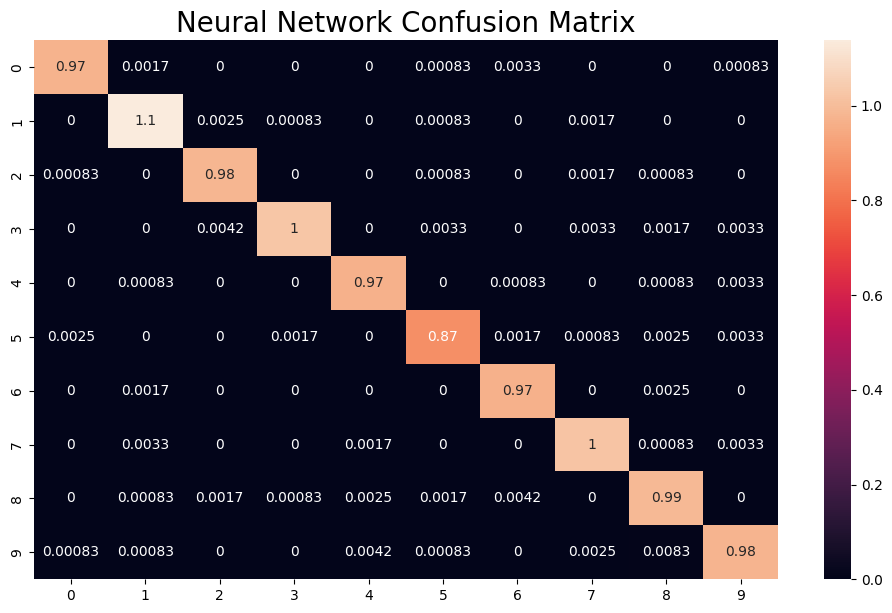

In [44]:
# Plot confusion matrix
confusion_matrix(num_classes, val_labels, predictions)

### Let's see how the Learning Rate Changes over time

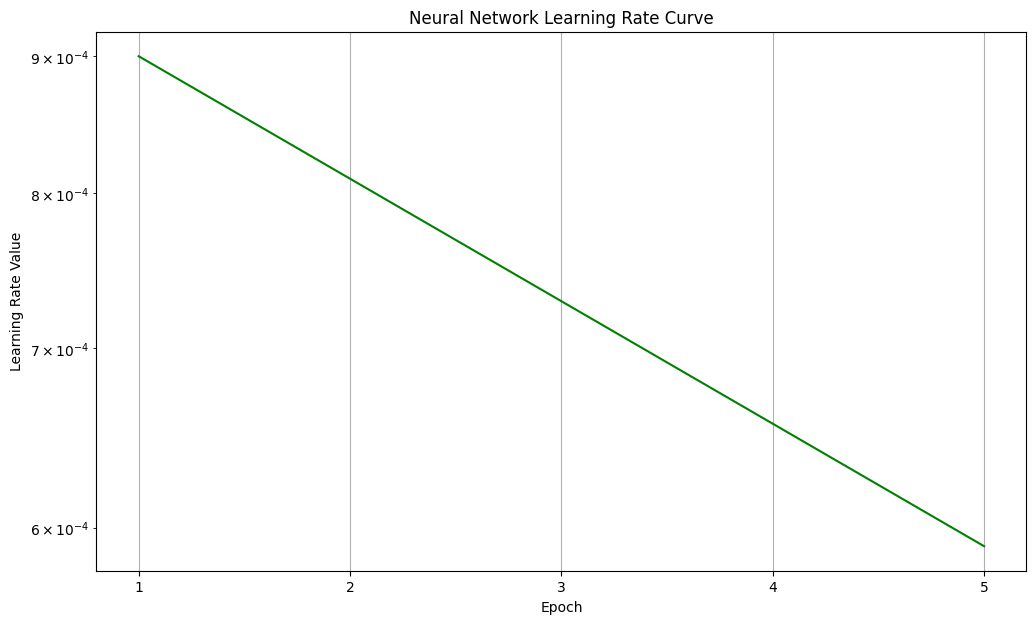

In [45]:
# Create list of epochs for plotting purposes
epoch_num = list(range(1, epochs+1))

plt.figure(figsize=(12,7))
plt.title("Neural Network Learning Rate Curve")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate Value")
plt.yscale("log")
plt.grid()
plt.plot(epoch_num, lrs, 'g-')
plt.xticks(epoch_num)
plt.show()

### Plot the model's training/loss curves

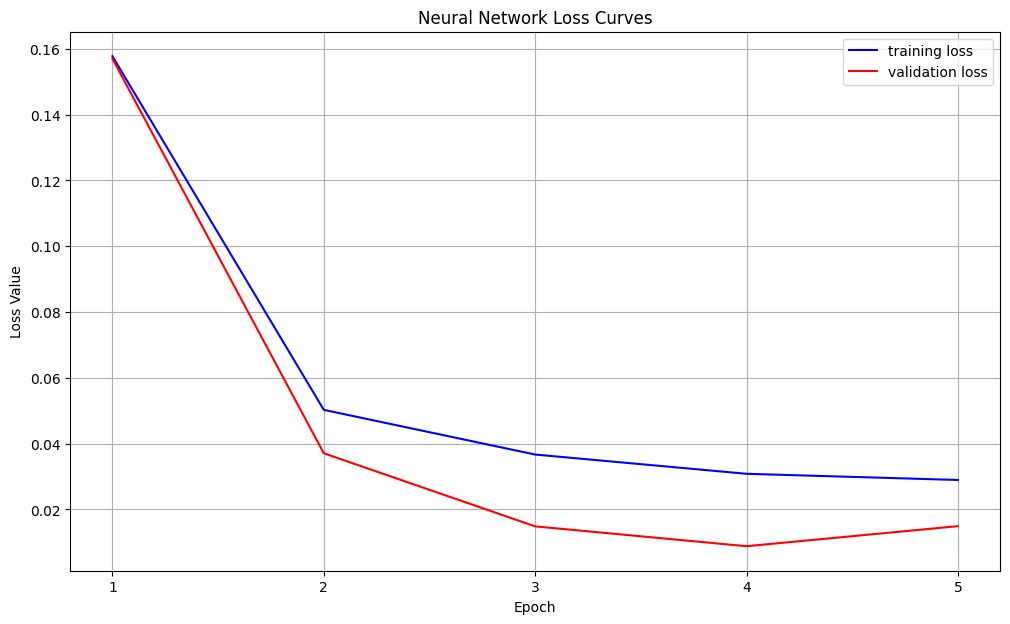

In [46]:
nl = [x / 1000 for x in train_loss]

plt.figure(figsize=(12,7))
plt.title("Neural Network Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.grid()
plt.plot(epoch_num, nl, 'b-', label='training loss')
plt.plot(epoch_num, val_loss, 'r-', label='validation loss')
plt.legend(loc="upper right")
plt.xticks(epoch_num)
plt.show()

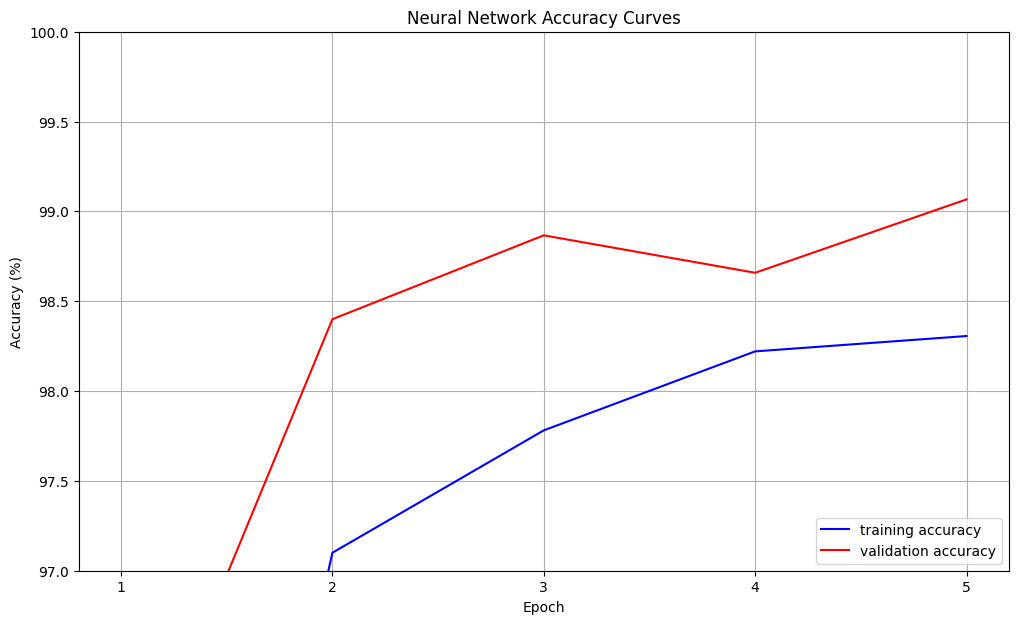

In [47]:
plt.figure(figsize=(12,7))
plt.title("Neural Network Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(97,100)
plt.grid()
plt.plot(epoch_num, train_acc, 'b-', label='training accuracy')
plt.plot(epoch_num, val_acc, 'r-', label='validation accuracy')
plt.legend(loc="lower right")
plt.xticks(epoch_num)
plt.show()

# Generate Predictions

In [48]:
# Add the test set to a torch.utils.data
test_dl = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Make sure the model is in eval mode!
net.eval()

# Create a tensor for predictions
predictions = torch.LongTensor().to(device) 

# Save the new predictions
for images in test_dl:
    preds = net(images.to(device))
    predictions = torch.cat((predictions, preds.argmax(dim=1)), dim=0)

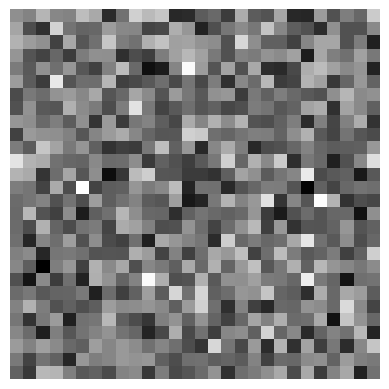

Predicted class: 4


In [49]:
# Example input image (replace this with an actual image tensor from your dataset)
# Assuming a single grayscale image of size 28x28
image = torch.randn(1, 28, 28)  # Replace with actual image data
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to the same device as the model

plt.imshow(image.squeeze(), cmap="gray")  # Remove channel dimension and use grayscale
plt.axis("off")
plt.show()

# Make the prediction
with torch.no_grad():  # Disable gradient calculation for inference
    output = net(image)
    predicted_class = output.argmax(dim=1).item()  # Get the class index

# Print the predicted class
print(f"Predicted class: {predicted_class}")